In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1913).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (209).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1381).jpg


In [2]:
import pandas as pd
import seaborn as sns
import tensorflow
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50,VGG16,VGG19
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG, load_img
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,MaxPooling2D,concatenate, Conv2DTranspose,Conv2D
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

2024-04-28 12:33:23.549571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 12:33:23.549665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 12:33:23.664313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_size=224
img_size_dim=[224,224]
dimension=(img_size,img_size)
zoom=[0.99,1.01]
bright=[0.8,1.2]
fill_mode='constant'
data_format='channels_last'
dir='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
data_gen=IDG(rescale=1./255,brightness_range=bright,zoom_range=zoom,data_format=data_format,fill_mode=fill_mode,horizontal_flip=True)
train_data_gen=data_gen.flow_from_directory(directory=dir,target_size=dimension,batch_size=12446,shuffle=False)

Found 12446 images belonging to 4 classes.


In [4]:
train_data_all,train_labels_all = next(train_data_gen)
print(train_data_all.shape,train_labels_all.shape)

(12446, 224, 224, 3) (12446, 4)


In [5]:
n = c = t = s = 0
for i in (train_labels_all):
    if i[0]==1:
        n+=1
    elif i[1]==1:
        c+=1
    elif i[2]==1:
        t+=1
    elif i[3]==1:
        s+=1
print("Normal: ",n,"\nCyst: ",c,"\nTumor: ",t,"\nStone: ",s)

Normal:  3709 
Cyst:  5077 
Tumor:  1377 
Stone:  2283


In [6]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)
train_data,val_data,train_labels,val_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True) 
from keras.applications.resnet50 import ResNet50

pretrained_model = ResNet50(include_top=False,
                             input_shape=(224, 224, 3),
                             pooling='max',
                             weights='imagenet')

pretrained_model.trainable=True
x=pretrained_model.output
a=Flatten()(x)
b=Dense(512,activation='relu')(a)
c=BatchNormalization()(b)
d=Dropout(0.5)(c)
e=Dense(4,activation='softmax')(d)
model=Model(inputs=pretrained_model.input,outputs=e)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,900 (94.00 MB)

 Trainable params: 24,586,756 (93.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [8]:
n = c = t = s = 0
for i in (train_labels):
    if i[0]==1:
        n+=1
    elif i[1]==1:
        c+=1
    elif i[2]==1:
        t+=1
    elif i[3]==1:
        s+=1
print("Normal: ",n,"\nCyst: ",c,"\nTumor: ",t,"\nStone: ",s)

Normal:  2972 
Cyst:  4037 
Tumor:  1104 
Stone:  1843


In [9]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
model.fit(train_data,train_labels,epochs=10,
                 validation_data=(val_data,val_labels))

Epoch 1/10


I0000 00:00:1714308031.874534      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714308031.969923      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8108 - loss: 0.5805

W0000 00:00:1714308149.903578      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714308157.738877      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 216s 446ms/step - accuracy: 0.8111 - loss: 0.5795 - val_accuracy: 0.2960 - val_loss: 2.1077
Epoch 2/10


W0000 00:00:1714308170.895224      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 95s 304ms/step - accuracy: 0.9803 - loss: 0.0581 - val_accuracy: 0.2960 - val_loss: 6.0189
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 94s 303ms/step - accuracy: 0.9854 - loss: 0.0423 - val_accuracy: 0.4092 - val_loss: 2.4344
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - accuracy: 0.9564 - loss: 0.1470 - val_accuracy: 0.9707 - val_loss: 0.0943
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - accuracy: 0.9968 - loss: 0.0085 - val_accuracy: 0.9390 - val_loss: 0.1558
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 94s 302ms/step - accuracy: 0.9544 - loss: 0.1423 - val_accuracy: 0.9900 - val_loss: 0.0305
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 94s 302ms/step - accuracy: 0.9974 - loss: 0.0106 - val_accuracy: 0.9309 - val_loss: 0.2066
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - accuracy: 0.9914 - loss: 0.0248 - val_accuracy: 0.9847 - val_loss: 0.0467
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 94s 302ms/step - accuracy: 0.9589 - loss: 0.1275 - val

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[1. 0. 0. 0.]]


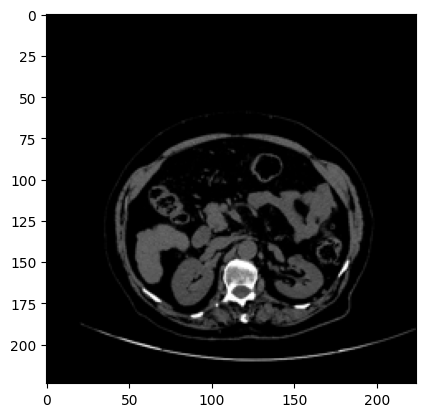

In [10]:
img=image.load_img("/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (58).jpg")
img=img.resize((224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
print(model.predict(x))
plt.imshow(img, cmap="jet")
plt.show()

In [11]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])
        
    def generate(self, image_array, class_idx):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(image_array)
            loss = predictions[:, class_idx]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]

        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image_array.shape[2], image_array.shape[1]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

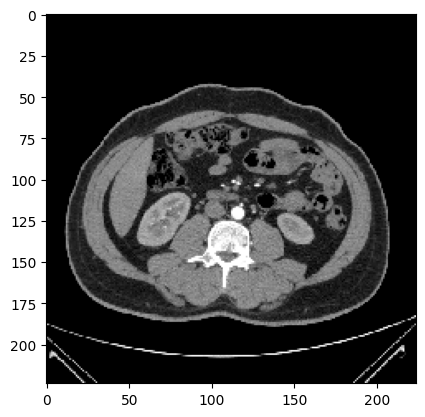

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)


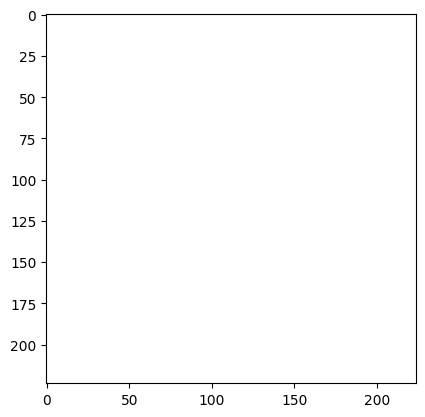

/tmp/ipykernel_34/3813149390.py:18: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


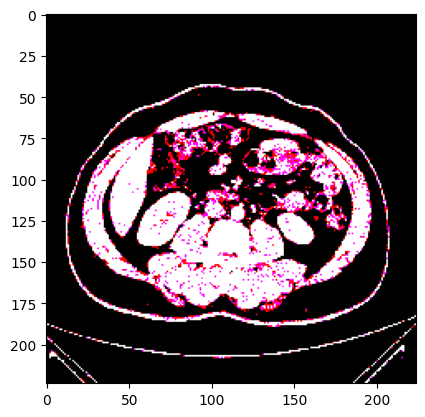

In [18]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'conv5_block3_3_conv')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)
plt.imshow(heatmap, cmap="jet")
plt.show()
# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
# cv2.imwrite('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg', superimposed_img)


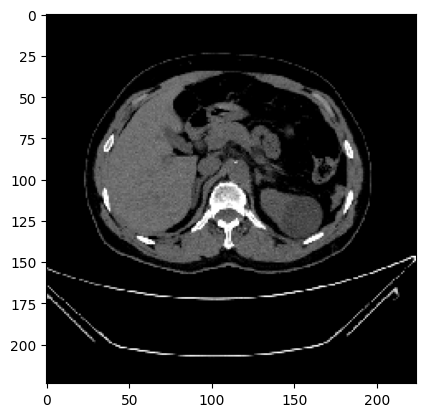

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)


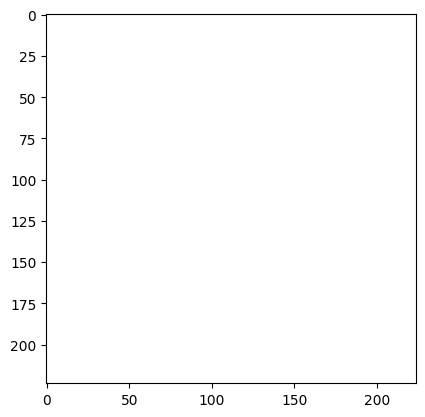

/tmp/ipykernel_34/626313149.py:18: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


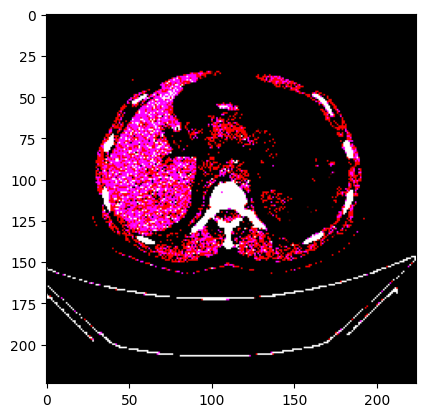

In [17]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'conv5_block3_3_conv')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)
plt.imshow(heatmap, cmap="jet")
plt.show()
# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.25 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
# cv2.imwrite('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg', superimposed_img)


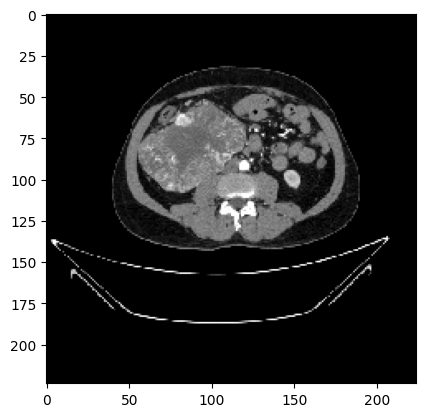

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)


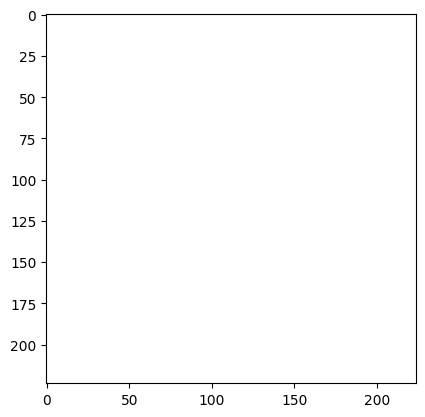

/tmp/ipykernel_34/3510113176.py:18: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


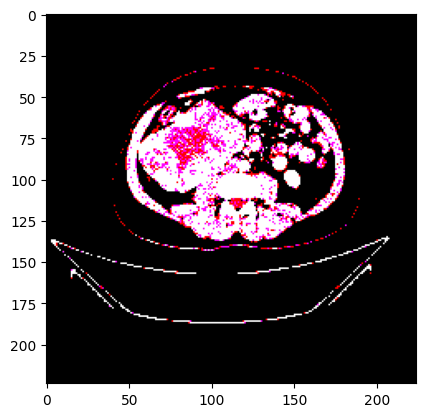

In [14]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (101).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'conv5_block3_3_conv')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)
plt.imshow(heatmap, cmap="jet")
plt.show()
# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
# cv2.imwrite('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg', superimposed_img)


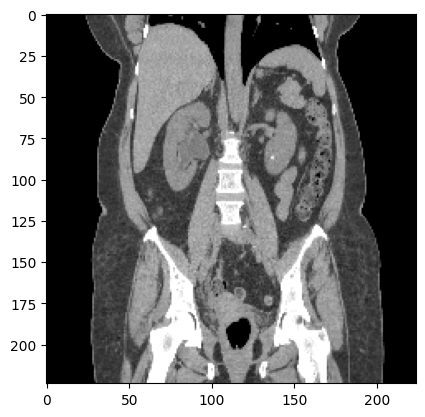

/tmp/ipykernel_34/2427944270.py:23: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)


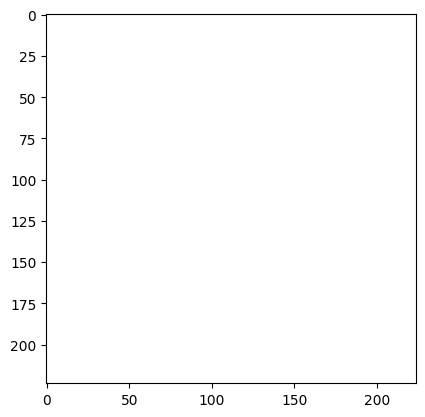

/tmp/ipykernel_34/4166336582.py:18: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


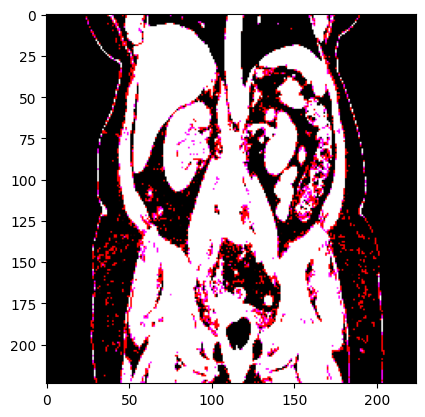

In [15]:
# Load and preprocess image
img_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (151).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img, cmap="jet")
plt.show()
# Initialize GradCAM
gradcam = GradCAM(model, 'conv5_block3_3_conv')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)
plt.imshow(heatmap, cmap="jet")
plt.show()
# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.35 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
# cv2.imwrite('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg', superimposed_img)


In [16]:
len(val_labels)

2490

In [ ]:
y_hat = model.predict(val_data)

In [ ]:
(y_hat[21:52])

In [ ]:
for i in range (len(y_hat)):
    yhi = int(max(y_hat[i]))
    yh = [0.0,0.0,0.0,0.0]
    yh[yhi] = 1.0
    y_hat[i] = yh
#     y_hat[i] = y_hat[i]